In [1]:
# toInstall = setdiff(c("MAGeCKFlute", "ggplot2", "Biobase", "ComplexHeatmap", "rcompanion"), installed.packages())
# BiocManager::install(toInstall)
# devtools::install_github("WubingZhang/ggView")

In [2]:
suppressMessages(library(ggView))
suppressMessages(library(MAGeCKFlute))
suppressMessages(library(ggplot2))
suppressMessages(library(Biobase))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(rcompanion))
options(stringsAsFactors = FALSE)
rm(list = ls())

In [3]:
trainDat = read.table("data/Training_data.txt", sep = "\t")
Degradability = readRDS("data/Donovan_Degradability.rds")
Degradability = Degradability[Degradability$IsKinase, ]

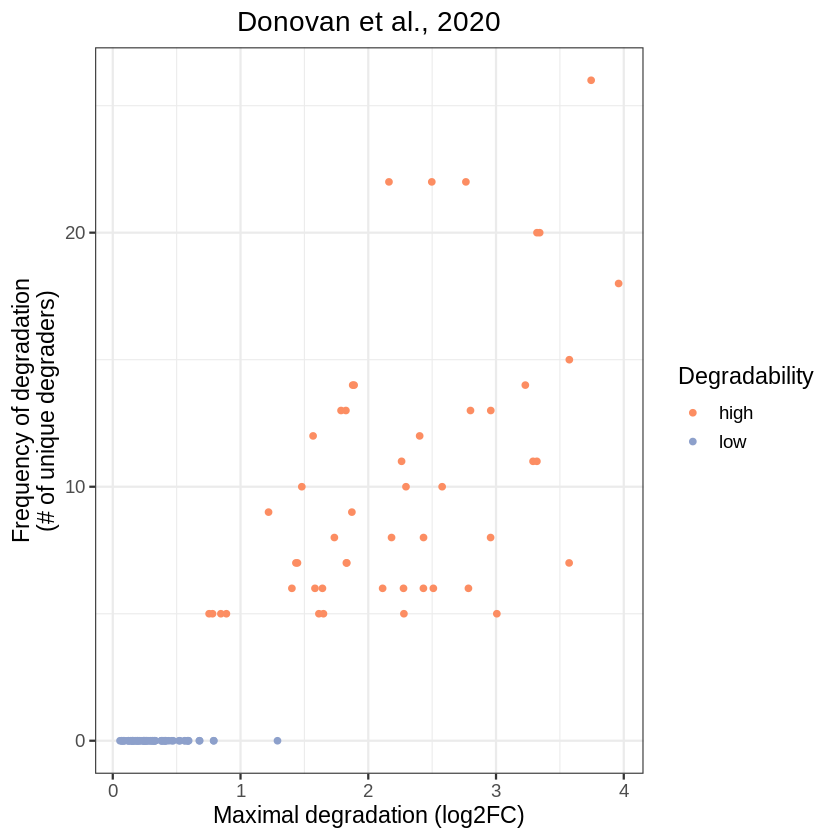

In [4]:
## Fig. 2a
gg = Degradability[rownames(trainDat), c("DegradeFreq", "DetectFreq", "MinLFC", "UniqDegradeFreq")]
gg$Group = factor(trainDat$Degradability, levels = c("high", "low"))
p = ggplot(gg, aes(MinLFC, UniqDegradeFreq, color = Group))
p = p + geom_point(size = 1.5, shape = 19)
p = p + labs(x = "Maximal degradation (log2FC)", y = "Frequency of degradation\n(# of unique degraders)", 
             color = "Degradability", title = "Donovan et al., 2020")
p = p + scale_color_manual(values = c("high"="#fc8d62", "low"="#8da0cb"))
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "right")
p

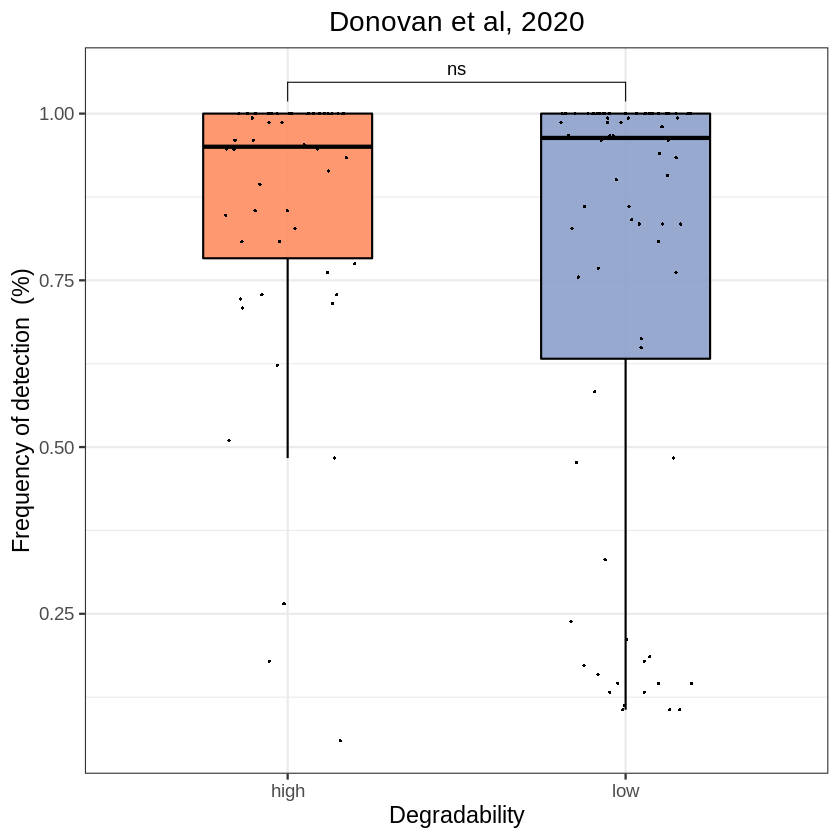

In [5]:
## Extended Data Fig. 1a
gg$DetectFreq = gg$DetectFreq / max(gg$DetectFreq)
p = BoxView(gg, "Group", "DetectFreq", xlab = "Degradability", ylab = "Frequency of detection  (%)", 
            alpha = 0.9, size = 0.6, fill = "Group", comparisons = list(c("low","high")), add.jitter = TRUE,
            main = "Donovan et al, 2020")
p = p + scale_fill_manual(values = c("#fc8d62", "#8da0cb"))
p = p + ylim(NA, 1.05)
p

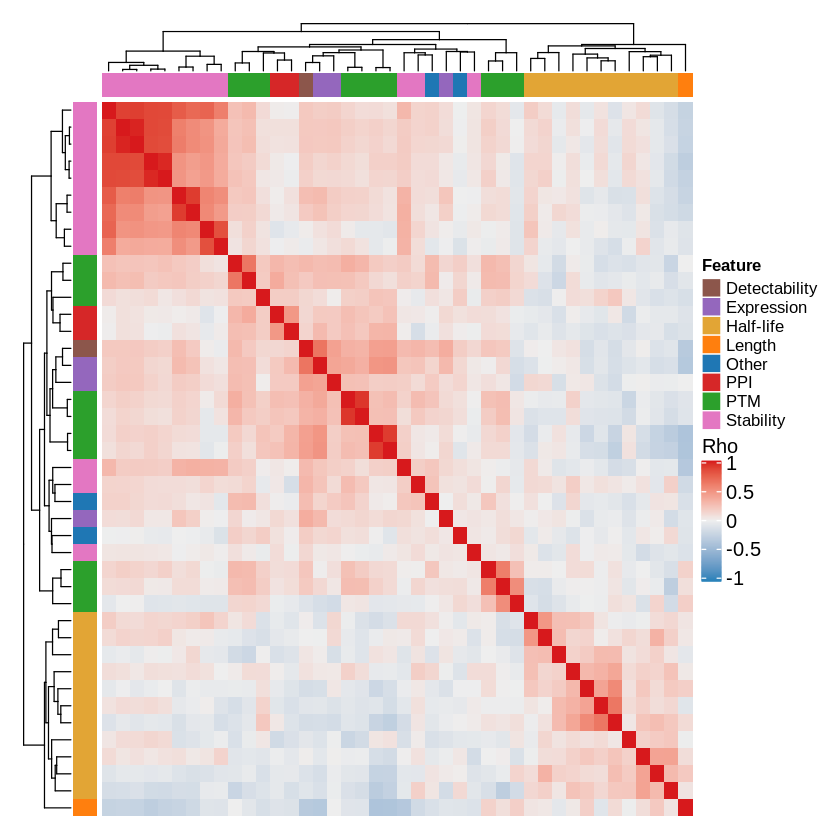

In [6]:
## Fig. 2b
gg = cor(trainDat[, -1], method = "spearman")
top_ann = data.frame(Feature = c("Length", "Other", rep("PTM", 10), "Other", rep("PPI", 2), 
                                 rep("Expression",3), "Detectability", rep("Stability", 12), 
                                 rep("Half-life", 11)), row.names = colnames(gg))
ann_col = c('#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
            '#e377c2', '#e2a535', '#17becf', '#bcbd22', '#7f7f7f')[1:8]
names(ann_col) = unique(top_ann$Feature)
top_ann_col = list(Feature = ann_col)
ggView::HeatmapView(gg, breaks = c(-1,0,1), colors = c("#2b83ba", "#EEEEEE", "#d7191c"),
                    cluster_rows = TRUE, cluster_cols = TRUE,
                    show_column_names = FALSE, show_row_names = FALSE, 
                    legend_title = "Rho", legend_title_position = "topleft", #right_ann = right_ann,
                    top_ann = top_ann, top_ann_col = top_ann_col, show_top_legend=FALSE,
                    left_ann = top_ann, left_ann_col = top_ann_col, legend_height = 1)

In [7]:
gg = apply(trainDat[,-1], 2, function(x){
  tmpH = na.omit(x[trainDat$Degradability=="high"])
  tmpL = na.omit(x[trainDat$Degradability=="low"])
  rg = rcompanion::wilcoxonZ(tmpH, tmpL)
  tmp = wilcox.test(tmpH, tmpL)
  c(rg, tmp$p.value)
})
gg = as.data.frame(t(gg))
colnames(gg) = c("Zscore", "Pval")
gg$FDR = p.adjust(gg$Pval, method = "fdr")
gg$logFDR = -log10(gg$FDR)
gg$Feature = rownames(gg)
gg$Category = c("Length", "Other", rep("PTM", 10), "Other", rep("PPI", 2), 
                rep("Expression",3), "Detectability", rep("Stability", 12), 
                rep("Half-life", 11))
tmp = aggregate(abs(gg$Zscore), list(Category=gg$Category), max)
tmp = tmp[order(-tmp$x), ]
gg$Category = factor(gg$Category, tmp$Category)
gg = gg[order(gg$Category, -gg$Zscore), ]
gg$Feature = factor(gg$Feature, levels = gg$Feature)
gg$signif = "ns"
gg$signif[gg$Pval<0.025] = "*"
gg$signif[gg$Pval<0.005] = "**"
gg$signif[gg$Pval<0.0005] = "***"
gg$signif_y = gg$Zscore+0.1
gg$signif_y[gg$Zscore<0] = gg$Zscore[gg$Zscore<0]-0.1
gg$axis_col = "black"
gg$axis_col[gg$Pval<0.025] = "red"

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


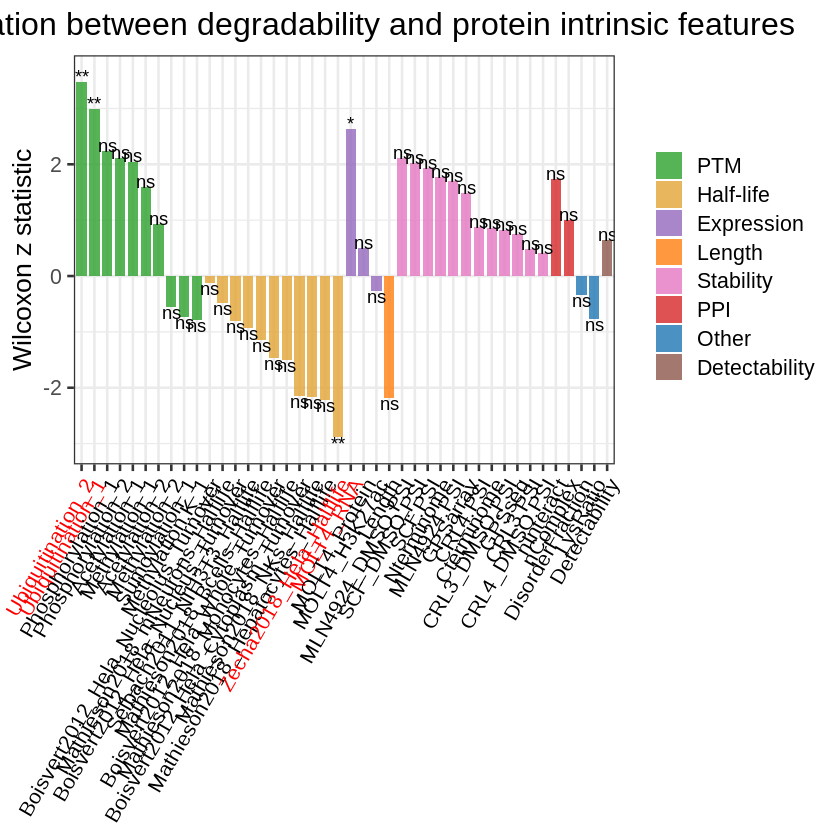

In [8]:
## Fig. 2c
p <- BarView(gg, "Feature", "Zscore", fill = "Category", alpha = 0.8)
p <- p + labs(title="Association between degradability and protein intrinsic features", 
              x=NULL, y = "Wilcoxon z statistic")
p <- p + geom_text(aes(y = signif_y, label = signif))
p <- p + ylim(min(gg$Zscore)-0.15, max(gg$Zscore)+0.15)
p <- p + scale_fill_manual(values = ann_col)
p <- p + theme_bw(base_size = 16)
p <- p + theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1, color = gg$axis_col),
               plot.title = element_text(hjust = 0.5))
p